In [5]:
import os
from matplotlib import pyplot as plt
from imutils import contours
import numpy as np
import imutils
import cv2

# set the path of origin pic and result.
# filepath 中图像应该是存在多个文件夹中的，每个文件夹的内容都包含一对正负样本。
# respath 用于存储结果
FILE_PATH = './compareSamples'
RES_PATH = './results'

# Traversal the sample folder
subDirs = [f.name for f in os.scandir(FILE_PATH) if f.is_dir()]
# eg. sample1
# for f in subDirs:
f = subDirs[0]
posPath = os.path.join(FILE_PATH, f + '/pos.png')
negPath = os.path.join(FILE_PATH, f + '/neg.png')
posImg = cv2.imread(posPath)
posImg = np.flip(posImg, axis=-1)
negImg = cv2.imread(negPath)
negImg = np.flip(negImg, axis=-1)
Samples = [posImg, negImg]

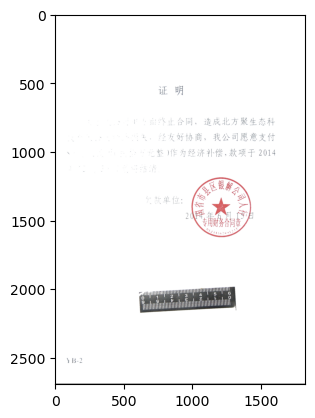

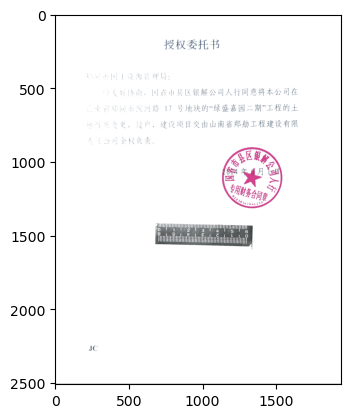

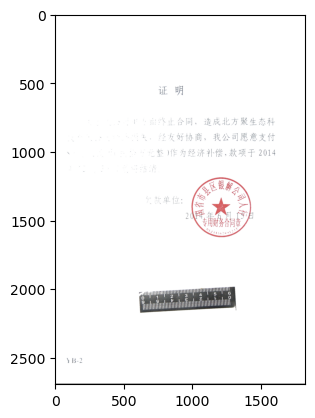

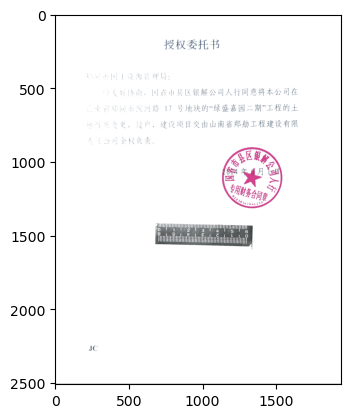

In [6]:
def getMask(r, g, b, img):
    # return higher than rgb
    R_mask = img[..., 0] > r
    G_mask = img[..., 1] > g
    B_mask = img[..., 2] > b
    return R_mask * G_mask * B_mask


# to mark pixel that satisfy conditions
def saveShow(img, name):
    import datetime
    date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    import matplotlib.pyplot as plt
    plt.imshow(img)
    import os
    if not os.path.exists('tempfile'):
        os.makedirs('tempfile')
    plt.savefig('tempfile/' + date + '_' + name + '.png', dpi=400)
    plt.show()


def saveShowCV(img, name):
    import datetime
    date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    name = date + name
    cv2.imshow(name, img)
    cv2.imwrite('tempfile' + name + '.png', img)


# show pics
def enhanceFeature(img, r, g, b, verbose=False, name='enhance'):
    img_ = img.copy()
    imgMask = negImgMask = getMask(r, g, b, img_)
    img_[imgMask] = [255, 255, 255]
    if verbose == True:
        saveShow(img_, name)
    return img_


# set black color
(r, g, b) = (154, 154, 154)
enhancedSample = []
for i, img in enumerate(Samples):
    enhancedSample.append(enhanceFeature(img, r, g, b, verbose=True, name=f + "_" + str(i) + "_" + 'enhance'))

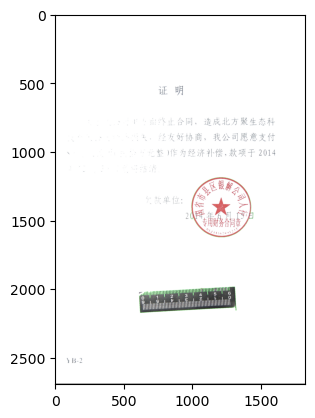

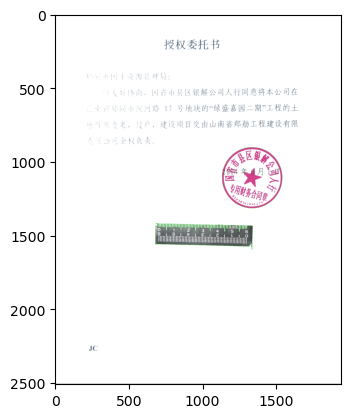

[0.6502984319002385, 0.6467719172797922]
the size similarity is 0.9945475143149718


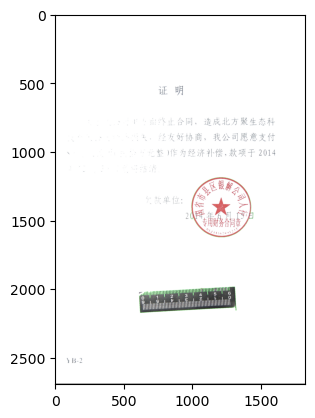

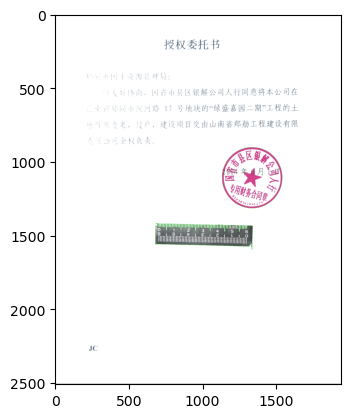

[0.6502984319002385, 0.6467719172797922]
the size similarity is 0.9945475143149718


In [7]:
# test get size of pic
# import the necessary packages
def compareRuleWithSeal(img, verbose=False, name=''):
    # gray the exaction pic
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    edged = cv2.Canny(gray, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts)
    pixelsPerMetric = None
    # sorted by contour area
    selectedCnts = sorted(cnts, key=cv2.contourArea)
    selectedCnts = selectedCnts[-2:]
    # get the largest two contour
    # the relevant ratio reflect size relation
    if verbose == True:
        img_ = img.copy()
        cv2.drawContours(img_, selectedCnts, -1, (0, 255, 0))
        name += '_top2contours'
        saveShow(img_, name)
    return (1.0 * cv2.contourArea(selectedCnts[0])) / cv2.contourArea(selectedCnts[1])


# contour area of two samples
area = []
for i in range(2):
    area.append(compareRuleWithSeal(enhancedSample[i], verbose=True, name=f + str(i)))
print(area)
# calculate similarity
sizeScore = 1 - abs((area[0] - area[1]) / area[1])
print('the size similarity is {}'.format(sizeScore))

上一个部分比较了图像的相对大小，原理在于图像中标尺的比例和印章的比例应当是一致的，因此无论图像如何缩放，印章的轮廓和标尺轮廓所覆盖的面积之比都是一样的。比较两个样本的面积比例，差异过大时就是有错误的。下面用于印章提取，对于一张图片而言需要捕捉其红色通道的内容，提取印章，以比对其细节。

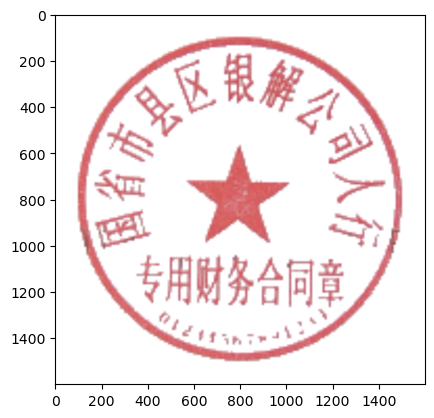

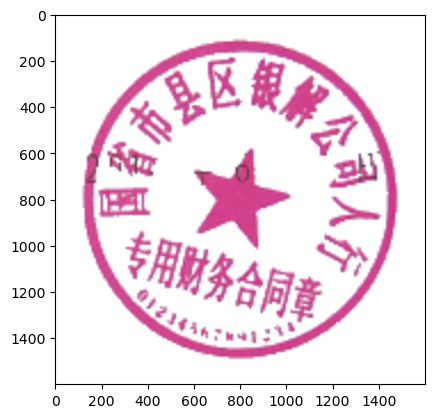

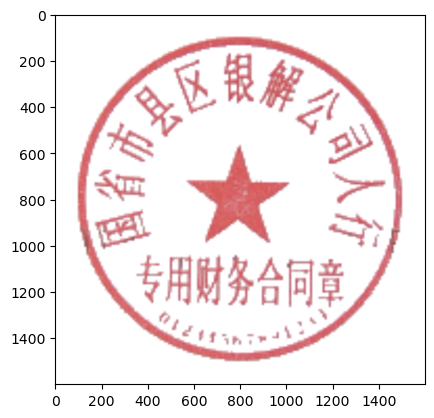

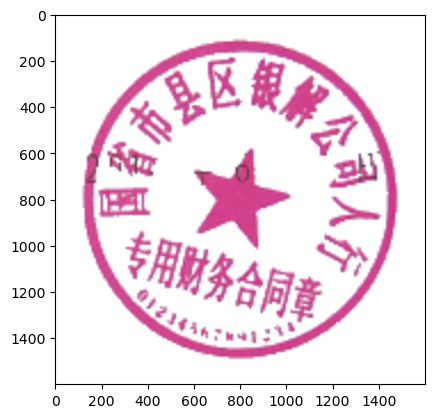

In [8]:
sampleSeal = []


# to save extracted seal
def exactSeal(img, verbose=True, out_size = 800,name='seal'):
    # 提取红色印章
    import cv2
    import numpy as np

    # 统一修改图片大小
    img_w = 650 if img.shape[1] > 600 else 400
    img = cv2.resize(img, (img_w, int(img_w * img.shape[0] / img.shape[1])), interpolation=cv2.IMREAD_COLOR)
    # 将原图转换为灰度图
    impng = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2RGBA)
    hue_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    low_range = np.array([130, 43, 46])
    high_range = np.array([180, 255, 255])
    th = cv2.inRange(hue_img, low_range, high_range)
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))  # 返回形状为矩形，大小为（1，1）的Mat类型数据
    th = cv2.dilate(th, element)  # 膨胀函数，用element来膨胀th图片
    index1 = th == 255
    print1 = np.zeros(impng.shape, np.uint8)
    print1[:, :, :] = (255, 255, 255, 0)
    print1[index1] = impng[index1]  # (0,0,255)
    #
    low_range = np.array([0, 43, 46])
    high_range = np.array([9, 255, 255])
    th = cv2.inRange(hue_img, low_range, high_range)
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    th = cv2.dilate(th, element)
    index1 = th == 255
    print2 = np.zeros(impng.shape, np.uint8)
    print2[:, :, :] = (255, 255, 255, 0)
    print2[index1] = impng[index1]

    # 合并图像增强效果
    imgreal = cv2.add(print2, print1)  # 合并图片为imgreal,这是个三维张量

    white_px = np.asarray([255, 255, 255, 255])  # 转化为多维数组
    (row, col, _) = imgreal.shape  # 按照imgreal的形状来
    for r in range(row):
        for c in range(col):
            px = imgreal[r][c]
            if all(px == white_px):
                imgreal[r][c] = impng[r][c]

    # 扩充图片防止截取部分
    print4 = cv2.copyMakeBorder(imgreal, 50, 50, 50, 50, cv2.BORDER_CONSTANT,
                                value=[255, 255, 255, 0])  # 复制源图像imgreal并生成边界
    print2gray = cv2.cvtColor(print4, cv2.COLOR_RGBA2GRAY)
    retval, grayfirst = cv2.threshold(print2gray, 254, 255, cv2.THRESH_BINARY_INV)  # 将图像进行二值化处理，凸显目标的轮廓

    element = cv2.getStructuringElement(cv2.MORPH_RECT, (22, 22))  # 返回形状为矩形，大小为（22，22）的Mat类型数据
    img6 = cv2.dilate(grayfirst, element)  # 膨胀函数

    c_canny_img = cv2.Canny(img6, 10, 10)  # 边缘检测函数,经过处理得到二值图像

    contours, hierarchy = cv2.findContours(c_canny_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # 检测出物体的轮廓
    areas = []
    for i, cnt in enumerate(contours):
        rect = cv2.minAreaRect(cnt)
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        ars = [area, i]
        areas.append(ars)
    areas = sorted(areas, reverse=True)
    # print(areas)
    maxares = areas[:1]

    x, y, w, h = cv2.boundingRect(contours[maxares[0][1]])
    print5 = print4[y:(y + h), x:(x + w)]
    # 处理高宽情况
    # print(print5.shape)
    if print5.shape[0] < print5.shape[1]:
        zh = int((print5.shape[1] - print5.shape[0]) / 2)
        print5 = cv2.copyMakeBorder(print5, zh, zh, 0, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255, 0])
    else:
        zh = int((print5.shape[0] - print5.shape[1]) / 2)
        print5 = cv2.copyMakeBorder(print5, 0, 0, zh, zh, cv2.BORDER_CONSTANT, value=[255, 255, 255, 0])
    realprint = cv2.resize(print5, (out_size, out_size))
    # 显示图片
    realprint = cv2.cvtColor(realprint, cv2.COLOR_RGBA2RGB)
    realprint = np.flip(realprint, axis=-1)
    if verbose == True:
        saveShow(realprint, name)
    return realprint


sampleSeal = []
OUT_SIZE = 1600
for i in range(2):
    sampleSeal.append(exactSeal(np.flip(Samples[i], axis=-1), True,OUT_SIZE, 'seal_{}'.format(i)))


在提取到印章图片之后，就需要对图像的差异之处进行对比。为了找到相似度不高的图像

In [0]:
__all__ = ['cv2']


#判断相似度，M是test印章的特征点数量，N是样本印章的特征点数量,n是特征向量数量
def judge_by_SIFT(M, N, n):
    MR = (2 * n) / (M + N)
    print("利用SIFT得出的相似度  " + str(MR))
    if MR > 0.7:
        return True
    else:
        return False

# 仅用于打分的SIFT
def SIFT_Flann_score(testprint, sampleprint):
    sift = cv2.xfeatures2d.SIFT_create()
    MinMatchNum = 4
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    kp1, des1 = sift.detectAndCompute(testprint, None)  # des是描述子

    kp2, des2 = sift.detectAndCompute(sampleprint, None)  # des是描述子

    if des1 is not None and des2 is not None :
        if len(des1)>1 and len(des2)>1:
            matches = flann.knnMatch(des1, des2, k=2)
        else:
            matches = flann.knnMatch(des1, des2, k=1)
    else:
        return 0
    # 调整ratio
    ratio = 0.90
    good = []
    #  如果最接近和次接近的比值大于一个既定的值，那么我们保留这个最接近的值，认为它和其匹配的点为good_match
    #  出现了不匹配的情况，用这个解决：https://stackoverflow.com/questions/31291993/flann-knn-matcher-in-opencv-returns-only-one-point-instead-of-a-pair
    for i in range(0, len(matches)):
        if len(matches[i]) == 1:
            m = matches[i][0]
            good.append([m])
        if len(matches[i]) > 1:
            (m,n) = matches[i]
            if m.distance < 0.75*n.distance:
                good.append([m])
                good.append([m])
    # for m, n in matches:
    #     if m.distance < ratio * n.distance:
    #         good.append(m)
    (M,N,n)=(len(kp1), len(kp2), len(good))
    return ( n) / (M + N) if (M+N)>0 else 0



# 基于FlannBasedMatcher的SIFT
def SIFT_Flann(testprint, sampleprint):
    sift = cv2.xfeatures2d.SIFT_create()
    MinMatchNum = 4
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    kp1, des1 = sift.detectAndCompute(testprint, None)  # des是描述子

    kp2, des2 = sift.detectAndCompute(sampleprint, None)  # des是描述子

    testprint = cv2.cvtColor(testprint, cv2.COLOR_BGR2RGB)  #会变成蓝色比对
    sampleprint = cv2.cvtColor(sampleprint, cv2.COLOR_BGR2RGB)

    matches = flann.knnMatch(des1, des2, k=2)
    # 调整ratio
    ratio = 0.90
    good = []
    #  如果最接近和次接近的比值大于一个既定的值，那么我们保留这个最接近的值，认为它和其匹配的点为good_match
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    judge_by_SIFT(len(kp1), len(kp2), len(good))
    if (len(good) > MinMatchNum):
        #获取关键点的坐标
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        ransacReprojThreshold = 4
        H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, ransacReprojThreshold)
        #H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold)
        matchesMask = mask.ravel().tolist()
        # 通过RANSAC得到的单应性矩阵对图片进行粗旋转
        imgOut = cv2.warpPerspective(testprint, H, (sampleprint.shape[1], sampleprint.shape[0]),
                                     flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP,borderValue=(255,255,255))
    else:
        print("Not enough matches are found - %d/%d" % (len(good), MinMatchNum))
        matchesMask = None
    #draw_params = dict(singlePointColor=None, matchesMask=matchesMask, flags=2)
    #imgWithLine = cv2.drawMatches(imgOut, kp1, sampleprint, kp2, good, None, **draw_params)
    imgOut = cv2.cvtColor(imgOut, cv2.COLOR_RGB2BGR)
    imgOutSam = cv2.cvtColor(sampleprint, cv2.COLOR_RGB2BGR)
    return imgOut, imgOutSam


#相似度采用单通道的直方图算法
def calculate(testprint, sampleprint):
    hist1 = cv2.calcHist([testprint], [0], None, [256], [0.0, 255.0])
    hist2 = cv2.calcHist([sampleprint], [0], None, [256], [0.0, 255.0])
    #计算直方图的重合度
    degree = 0
    for i in range(len(hist1)):
        if hist1[i] != hist2[i]:
            degree = degree + (1 - abs(hist1[i] - hist2[i]) / max(hist1[i], hist2[i]))
        else:
            degree = degree + 1
    return degree


def ow_rotate(image, angle, center=None, scale=1.0):
    # grab the dimensions of the image
    (h, w) = image.shape[:2]

    # if the center is None, initialize it as the center of
    # the image
    if center is None:
        center = (w // 2, h // 2)
    # from cv2 import cv2
    # perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    # rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0,255,205))
    # rotated = cv2.warpAffine(image, M, (w, h),cv2.INTER_LINEAR, cv2.BORDER_CONSTANT, 255)
    # rotated = cv2.warpAffine(image, M, (w, h),cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
    rotated = cv2.warpAffine(image, M, (w, h),borderValue=(255,255,255))

    # return the rotated image
    return rotated


#精旋转 直到相似度最大，转的是testprint，以起始点为准，正转30次，反转30次，每次0.1°，共正负3度
def rotate(testprint, sampleprint):
    Similarity_1 = []  #顺
    Similarity_1.append(calculate(testprint, sampleprint))
    testprint1 = testprint.copy()
    Similarity_2 = []  #逆
    Similarity_2.append(calculate(testprint, sampleprint))
    testprint2 = testprint.copy()
    for i in range(0, 31):
        testprint1 = ow_rotate(testprint1, angle=0.1)
        Similarity_1.append(calculate(testprint1, sampleprint))
    #逆时针
    for i in range(0, 31):
        testprint2 = ow_rotate(testprint2, angle=-0.1)
        Similarity_2.append(calculate(testprint2, sampleprint))

    if (max(Similarity_1) > max(Similarity_2)):
        angle = Similarity_1.index(max(Similarity_1))
        testprint_rot = ow_rotate(testprint, angle=angle * 0.1)
        print(angle * 0.1)
    else:
        angle = Similarity_2.index(max(Similarity_2))
        testprint_rot = ow_rotate(testprint, angle=angle * (-0.1))
        print(angle * (-0.1))

        # to replace black to white
    # mask = cv2.inRange(testprint_rot,np.asarray([0, 0, 0]), np.asarray([0, 0, 0]))
    # testprint_rot[mask > 0] = [255, 255, 255]
    return testprint_rot


testprint, sampleprint = SIFT_Flann(sampleSeal[0], sampleSeal[1])
testprint = rotate(testprint, sampleprint)

# plt.imshow(testprint)
# plt.show()
# plt.imshow(sampleprint)
# plt.show()
BLOCK_NUM = 40
BLOCK_SIZE = OUT_SIZE//BLOCK_NUM
matchScores = np.zeros((OUT_SIZE,OUT_SIZE))

# split 400*400 pic into 5*5 pieces , with size of 80*80
for i in range(BLOCK_NUM):
    for j in range(BLOCK_NUM):
        # print("({},{})".format(i,j))
        matchScores[i*BLOCK_SIZE:(i+1)*BLOCK_SIZE,
                    j*BLOCK_SIZE:(j+1)*BLOCK_SIZE] = SIFT_Flann_score(testprint[i*BLOCK_SIZE:(i+1)*BLOCK_SIZE,
                                                                                j*BLOCK_SIZE:(j+1)*BLOCK_SIZE],
                                                                      sampleprint[i*BLOCK_SIZE:(i+1)*BLOCK_SIZE,
                                                                                j*BLOCK_SIZE:(j+1)*BLOCK_SIZE])
matchScores[matchScores==0]=1

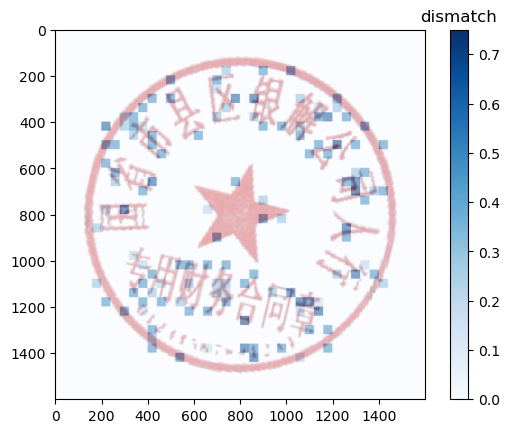

In [51]:
# to fix chinese error
# https://stackoverflow.com/questions/39630928/how-to-plot-a-figure-with-chinese-characters-in-label?noredirect=1&lq=1
from matplotlib import font_manager

# fontP = font_manager.FontProperties()
# fontP.set_family('SimHei')
# https://blog.csdn.net/didi_ya/article/details/107528570
# fix font missing error
plt.clf()
ax = plt.subplot()
# ax.imshow(testprint)
img = ax.imshow(1-matchScores,cmap='Blues')

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right',size='5%',pad=0.05)
clb=plt.colorbar(img)


clb.ax.set_title('dismatch')
ax.imshow(testprint,alpha=0.5)
plt.show()

In [15]:
np.max(matchScores)
np.min(matchScores)


0.4